In [2]:
!pip install "sqlalchemy_mate<2.0.0"
!pip install uszipcode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.38
    Uninstalling SQLAlchemy-2.0.38:
      Successfully uninstalled SQLAlchemy-2.0.38
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.0 MB/s eta 0:00:00
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6941 sha256=7fb0de82b86245abe14803c477f9183172c35740b1412c8cc74010ea06696140
  Stored in directory: /root/.cache/pip/wheels/f7/99/9c/d24e98c35f30eba0c367ad1e7888d396d676abb35fe1e7611c
Successful

In [3]:
import kagglehub
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
import re
from uszipcode import SearchEngine

#!pip install "sqlalchemy_mate<2.0.0" USE THIS VERSION TO AVOID IMPORT ERRORS FROM USZIPCODE

# CPI data
cpi_data = {
    1913: 9.9, 1914: 10.0, 1915: 10.1, 1916: 10.9, 1917: 12.8, 1918: 15.0, 1919: 17.3, 1920: 20.0,
    1921: 17.9, 1922: 16.8, 1923: 17.1, 1924: 17.1, 1925: 17.5, 1926: 17.7, 1927: 17.4, 1928: 17.2,
    1929: 17.2, 1930:  16.7, 1931: 15.2, 1932: 13.6, 1933: 12.9, 1934: 13.4, 1935: 13.7, 1936: 13.9,
    1937: 14.4, 1938: 14.1, 1939: 13.9, 1940: 14.0, 1941: 14.7, 1942: 16.3, 1943: 17.3, 1944: 17.6,
    1945: 18.0, 1946: 19.5, 1947: 22.3, 1948: 24.0, 1949: 23.8, 1950: 24.1, 1951: 26.0, 1952: 26.6,
    1953: 26.8, 1954: 26.9, 1955: 26.8, 1956: 27.2, 1957: 28.1, 1958: 28.9, 1959: 29.2, 1960: 29.6,
    1961: 29.9, 1962: 30.3, 1963: 30.6, 1964: 31.0, 1965: 31.5, 1966: 32.5, 1967: 33.4, 1968: 34.8,
    1969: 36.7, 1970: 38.8, 1971: 40.5, 1972: 41.8, 1973: 44.4, 1974: 49.3, 1975: 53.8, 1976: 56.9,
    1977: 60.6, 1978: 65.2, 1979: 72.6, 1980: 82.4, 1981: 90.9, 1982: 96.5, 1983: 99.6, 1984: 103.9,
    1985: 107.6, 1986: 109.6, 1987: 113.6, 1988: 118.3, 1989: 124.0, 1990: 130.7, 1991: 136.2,
    1992: 140.3, 1993: 144.5, 1994: 148.2, 1995: 152.4, 1996: 156.9, 1997: 160.5, 1998: 163.0, 1999: 166.6,
    2000: 172.2, 2001: 177.1, 2002: 179.9, 2003: 184.0, 2004: 188.9, 2005: 195.3, 2006: 201.6, 2007: 207.3,
    2008: 215.3, 2009: 214.5, 2010: 218.1, 2011: 224.9, 2012: 229.6, 2013: 233.0, 2014: 236.7, 2015: 237.0,
    2016: 240.0, 2017: 245.1, 2018: 251.1, 2019: 255.7, 2020: 258.8, 2021: 270.9,
    2022: 292.0, 2023: 306.8, 2024: 315.6
}

# Download latest version
path = kagglehub.dataset_download("syedanwarafridi/vehicle-sales-data")
path2 = kagglehub.dataset_download("tsaustin/us-used-car-sales-data")
path = path + "/car_prices.csv"
path2 = path2 + "/used_car_sales.csv"


# Load Data
df1 = pd.read_csv(path)
df2 = pd.read_csv(path2)

print("DATA LOADED")

# Extract Year from Sale Date
df1["sale_year"] = df1["saledate"].str.extract(r'(\d{4})').astype(float).astype("Int64")

# Preprocessing

# Drop Columns
df1 = df1.drop(columns=['body', 'transmission', 'vin', 'seller', "saledate"])
df2 = df2.drop(columns=['Engine', 'BodyType', 'NumCylinders', 'DriveType', 'ID'])


# Rename Columns for Merging
df2.rename(columns={
    "pricesold": "sellingprice",
    "Make": "make",
    "Year": "year",
    "Model": "model",
    "Trim": "trim",
    "Mileage": "odometer",
    "yearsold": "sale_year"
}, inplace=True)

# Replace Missing Values
df1 = df1.replace([" ", "NA", "na", "--", "null"], pd.NA)

# Drop Unfillable NA Values
df1 = df1.dropna(subset=['make', 'model', 'trim', 'color', 'interior', 'sale_year'])

# Fill NA Values with Median
df1['condition'] = df1['condition'].fillna(df1['condition'].median())
df1['odometer'] = df1['odometer'].fillna(df1['year'] * 10000) # assume 10000 miles per year
df1['mmr'] = df1['mmr'].fillna(df1['mmr'].median())

# MALO FILL DF2 MISSING VALUES HERE FROM NOTES ONCE DONE WITH THAT WE CAN UNCOMMENT MERGE DATAFRAMES BELOW
# STATE CORRECTION HERE AS WELL
search = SearchEngine()
def get_state(zipcode):
    zipcode_str = str(zipcode).strip()

    # Full zipcode: exactly 5 digits
    if re.fullmatch(r'\d{5}', zipcode_str):
        result = search.by_zipcode(zipcode_str)
        if result and result.state:
            return result.state
        else:
            return "Unknown"
    # Partial zipcode: 3 digits followed by two asterisks, e.g., "940**"
    elif re.fullmatch(r'\d{3}\*\*', zipcode_str):
        prefix = zipcode_str[:3]
        # Query for any zipcode that starts with the prefix
        results = search.query(prefix + "*", returns=1)
        if results and results[0].state:
            return results[0].state
        else:
            return "Unknown"
    else:
        # For any other format, return "Unknown"
        return "Unknown"
df2['state'] = df2['zipcode'].apply(get_state)
df2['trim'] = df2['trim'].fillna("Unknown")


# Replace empty strings (or strings with just spaces) with "unknown"
df2.loc[df2['trim'].str.strip() == "", 'trim'] = "Unknown"

"""
still missing values in model, condition, mmr, interior, color
"""

# Merge DataFrames and Save to CSV
merged_df = pd.concat([df1, df2], ignore_index=True)

merged_df.dropna(subset= ["model"], inplace= True)
merged_df['condition'] = merged_df['condition'].fillna(merged_df['condition'].median())
merged_df['mmr'] = merged_df['mmr'].fillna(merged_df['mmr'].median())
merged_df["color"] = merged_df["color"].fillna(merged_df["color"].mode()[0])
merged_df["interior"] = merged_df["interior"].fillna(merged_df["interior"].mode()[0])

# SAVE TO CSV DO NOT COMMIT DATASETS
merged_df.to_csv("merged_data.csv", index= False)

# Convert sale_price to 2024 dollars
merged_df["2024_price"] = merged_df["sellingprice"] * (cpi_data[2024] / merged_df["sale_year"].map(cpi_data))

merged_df.dropna(subset= ["2024_price"], inplace= True)

# Save to CSV
merged_df.to_csv("merged_data_2024_column.csv", index= False)

# Summaries
# missing_summary_df1 = pd.DataFrame({
#     "Missing Values": df1.isnull().sum(),
#     "Missing Percentage (%)": (df1.isnull().sum() / len(df1)) * 100
# })
# print(missing_summary_df1)


# missing_summary_df2 = pd.DataFrame({
#     "Missing Values": df2.isnull().sum(),
#     "Missing Percentage (%)": (df2.isnull().sum() / len(df2)) * 100
# })
# print(missing_summary_df2)



# SHAWN FILL IN ROW ADJUSTED INFLATION HERE


# Convert CPI data to a DataFrame
cpi_df = pd.DataFrame(list(cpi_data.items()), columns=['cpi_year', 'cpi'])
cpi_df['inflation_factor'] = cpi_df['cpi'].apply(lambda x: cpi_data[2024] / x)

# Assign inflation factor for 2024 explicitly
cpi_df.loc[cpi_df['cpi_year'] == 2024, 'inflation_factor'] = 1.0

# Extract the sale year from saledate
# df1['sale_year'] = df1['saledate'].dt.year already done above

# Ensure no duplicate columns exist before merging
if 'inflation_factor' in df1.columns:
    df1 = df1.drop(columns=['inflation_factor'])

# Merge CPI inflation
df1 = df1.merge(cpi_df[['cpi_year', 'inflation_factor']], left_on='sale_year', right_on='cpi_year', how='left')
df1 = df1.drop(columns=['cpi_year'])  # Drop the CPI year

# Step 1: Get unique combinations of year and trim
unique_combinations = df1[['year', 'trim']].drop_duplicates()

# Step 2: Generate 2024 rows for unique combinations
def generate_2024_rows(chunk):
    results = []
    for _, row in chunk.iterrows():
        new_row = row.copy()
        new_row['saledate'] = pd.Timestamp('2024-01-01')  # Set sale date to 2024
        new_row['sale_year'] = 2024  # Set sale year to 2024
        # Use the CPI formula for inflation adjustment
        new_row['sellingprice'] = df1.loc[
            (df1['year'] == row['year']) & (df1['trim'] == row['trim']),
            'sellingprice'
        ].mean() * (cpi_data[2024] / cpi_data[row['year']])
        new_row['inflation_factor'] = 1.0  # Inflation factor for 2024 is 1
        results.append(new_row)
    return pd.DataFrame(results)

# Step 3: Process unique combinations with multiprocessing
def chunkify(dataframe, n_chunks):
    chunk_size = int(np.ceil(len(dataframe) / n_chunks))
    return [dataframe.iloc[i:i + chunk_size] for i in range(0, len(dataframe), chunk_size)]

if __name__ == '__main__':
    num_cores = min(cpu_count(), 4)  # Use up to 4 cores
    chunks = chunkify(unique_combinations, num_cores)  # Split unique combinations into chunks

    with Pool(num_cores) as pool:
        results = pool.map(generate_2024_rows, chunks)

    # Combine results from all processes
    generated_rows_df = pd.concat(results, ignore_index=True)

    # Combine the generated rows
    extended_df = pd.concat([df1, generated_rows_df], ignore_index=True)

    # Format the saledate
    extended_df['saledate'] = pd.to_datetime(extended_df['saledate']).dt.strftime('%m/%d/%Y')

    # Save the extended DataFrame to a CSV file
    extended_df.to_csv("extended_data.csv", index= False)

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


100%|██████████| 18.8M/18.8M [00:01<00:00, 13.6MB/s]

Extracting files...


100%|██████████| 3.44M/3.44M [00:00<00:00, 3.80MB/s]

Extracting files...


DATA LOADED


<ipython-input-3-565e9b8b286b>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['condition'] = df1['condition'].fillna(df1['condition'].median())
<ipython-input-3-565e9b8b286b>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['odometer'] = df1['odometer'].fillna(df1['year'] * 10000) # assume 10000 miles per year
<ipython-input-3-565e9b8b286b>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.2 MB/s eta 0:00:00


In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

# Function to downcast numeric columns to reduce memory usage
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Initial memory usage: {:.2f} MB".format(start_mem))
    for col in df.columns:
        if df[col].dtype != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.api.types.is_integer_dtype(df[col]):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # For float types
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print("Optimized memory usage: {:.2f} MB".format(end_mem))
    return df

# Load merged_data.csv with low_memory=False and downcast numeric types
df = pd.read_csv("merged_data.csv", low_memory=False)
df = reduce_mem_usage(df)

# Use sellingprice as target variable
df = df.dropna(subset=["sellingprice"])

# Optionally, sample a fraction of the data if it’s very large.
sample_frac = 0.5
df = df.sample(frac=sample_frac, random_state=42)

# Separate target and features
X = df.drop(columns=["sellingprice"])
y = df["sellingprice"]

# Define categorical columns
categorical_cols = ["make", "model", "trim", "color", "interior", "state", "zipcode"]

# Separate numeric columns (all columns not in categorical_cols)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Split the DataFrame into categorical and numeric features
X_cat = X[categorical_cols]
X_num = X[numeric_cols]

# One-hot encode categorical features with sparse output using the new parameter name
encoder = OneHotEncoder(sparse_output=True, drop='first', handle_unknown='ignore')
X_cat_sparse = encoder.fit_transform(X_cat)

# Convert numeric features to a sparse matrix
X_num_sparse = sparse.csr_matrix(X_num.values)

# Combine numeric and categorical features into one sparse matrix
X_sparse = sparse.hstack([X_num_sparse, X_cat_sparse]).tocsr()

# Split data into training and test sets (20% test split)
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.2, random_state=42
)

# Define a parameter grid for LightGBM hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [-1, 10, 20]
}

# Initialize LightGBM regressor
lgb_reg = lgb.LGBMRegressor(random_state=42)

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(
    estimator=lgb_reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score (negative MSE):", grid.best_score_)

# Evaluate the best model on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R2:", r2)

# Feature importance
importances = best_model.feature_importances_
print("Shape of X_train:", X_train.shape)
print("Number of feature importances:", len(importances))


Initial memory usage: 66.34 MB
Optimized memory usage: 48.48 MB


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.399495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4556
[LightGBM] [Info] Number of data points in the train set: 267567, number of used features: 1949
[LightGBM] [Info] Start training from score 13139.383347
Best Parameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50}
Best CV Score (negative MSE): -16191634.24983173


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Test MSE: 15099024.929510733
Test R2: 0.8622390439669085
Shape of X_train: (267567, 31175)
Number of feature importances: 31175


# CLUSTERING

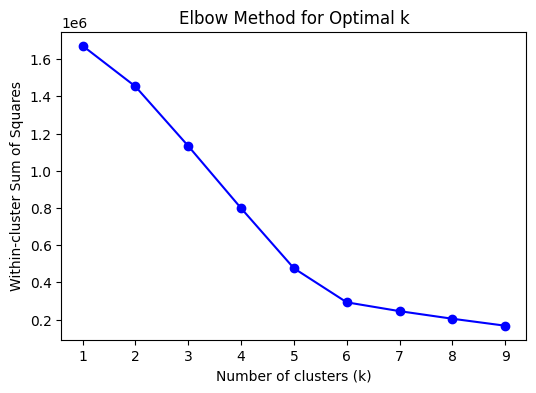

cluster
0    224013
1    110376
4        61
3         5
2         4
Name: count, dtype: int64


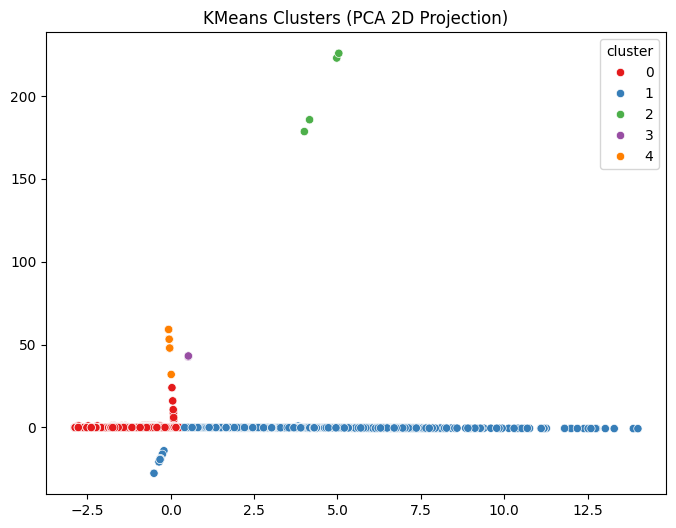

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=['number'])

columns_to_exclude = ["sellingprice"]

numeric_df = numeric_df.drop(columns=columns_to_exclude, errors='ignore')

# 4. Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_df)

#elbow method to pick an optimal k
wcss = []  # within-cluster sum of squares
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    wcss.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, wcss, 'bo-')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster Sum of Squares")
plt.show()

#Fit KMeans with your chosen number of clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_features)

# 6. Assign cluster labels back to original DataFrame
df['cluster'] = kmeans.labels_

# Print cluster counts
print(df['cluster'].value_counts())

#Visualize clusters in 2D with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=df['cluster'], palette='Set1')
plt.title("KMeans Clusters (PCA 2D Projection)")
plt.show()

In [8]:
df.head()

,year,make,model,trim,state,condition,odometer,color,interior,mmr,sellingprice,sale_year,zipcode,cluster
668417,1968,Chevrolet,Camaro,Z/28,Unknown,35.0,65000.0,black,black,12350.0,49700.0,2020,972**,0
30105,2014,Ram,1500,Sport,nv,44.0,16318.0,white,black,34400.0,33500.0,2014,NaN,1
69945,2011,Nissan,Rogue,SV,ca,41.0,41945.0,—,gray,13150.0,15000.0,2015,NaN,2
224275,2009,GMC,Acadia,SLE-1,nj,22.0,84964.0,red,gray,11350.0,9300.0,2015,NaN,0
390651,2014,Ford,Fusion,SE,oh,49.0,11642.0,red,tan,17350.0,17500.0,2015,NaN,2


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 4. Identify categorical vs. numerical columns
categorical_cols = ["make", "model", "trim", "color", "interior", "state", "zipcode"]
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove any columns from numerical_cols that shouldn't be used as features
#'sellingprice', 'cluster'
exclude_cols = ["sellingprice", "cluster"]
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

regression_results = {}

# 5. Loop through each cluster and train separate Ridge/Lasso models
for cluster_id in df["cluster"].unique():
    print(f"--- Training Models for Cluster {cluster_id} ---")

    # Subset the DataFrame for this cluster
    cluster_df = df[df["cluster"] == cluster_id].copy()

    # Define X and y for this cluster
    # Drop 'sellingprice' (the target) and 'cluster' (not a predictor) from features
    X = cluster_df.drop(columns=["sellingprice", "cluster"], errors="ignore")
    y = cluster_df["sellingprice"]

    # Encode categorical columns within this cluster’s subset
    for col in categorical_cols:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))

    # (Optional) You can also scale numeric columns here if you like

    # 6. Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 7. Initialize models
    ridge_model = Ridge(alpha=10)
    lasso_model = Lasso(alpha=0.01)

    # 8. Fit models
    ridge_model.fit(X_train, y_train)
    lasso_model.fit(X_train, y_train)

    # 9. Make predictions
    ridge_y_pred = ridge_model.predict(X_test)
    lasso_y_pred = lasso_model.predict(X_test)

    # 10. Evaluate
    ridge_rmse = root_mean_squared_error(y_test, ridge_y_pred)
    lasso_rmse = root_mean_squared_error(y_test, lasso_y_pred)

    ridge_r2 = r2_score(y_test, ridge_y_pred)
    lasso_r2 = r2_score(y_test, lasso_y_pred)

    # 11. Store results
    regression_results[cluster_id] = {
        "Ridge": {"model": ridge_model, "RMSE": ridge_rmse, "R2": ridge_r2},
        "Lasso": {"model": lasso_model, "RMSE": lasso_rmse, "R2": lasso_r2},
    }

    # Print cluster results
    print(f"Cluster {cluster_id}:")
    print(f"  Ridge -> RMSE: {ridge_rmse:.2f}, R2: {ridge_r2:.2f}")
    print(f"  Lasso -> RMSE: {lasso_rmse:.2f}, R2: {lasso_r2:.2f}\n")

--- Training Models for Cluster 0 ---
Cluster 0:
  Ridge -> RMSE: 7412.82, R2: 0.29
  Lasso -> RMSE: 7412.82, R2: 0.29

--- Training Models for Cluster 1 ---
Cluster 1:
  Ridge -> RMSE: 1737.58, R2: 0.97
  Lasso -> RMSE: 1737.58, R2: 0.97

--- Training Models for Cluster 3 ---
Cluster 3:
  Ridge -> RMSE: 389.47, R2: nan
  Lasso -> RMSE: 111.36, R2: nan

--- Training Models for Cluster 4 ---
Cluster 4:
  Ridge -> RMSE: 9866.98, R2: -0.37
  Lasso -> RMSE: 9764.99, R2: -0.34

--- Training Models for Cluster 2 ---
Cluster 2:
  Ridge -> RMSE: 81.01, R2: nan
  Lasso -> RMSE: 306.73, R2: nan



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.15035e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e+00, tolerance: 1.167e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/

#lightBGM on clusters

In [20]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


categorical_cols = ["make", "model", "trim", "state", "color", "interior", "zipcode"]

# 4. Encode ALL categorical columns in the entire DataFrame
for col in categorical_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 5. Per-cluster LightGBM
lightgbm_results = {}
for cluster_id in df["cluster"].unique():
    print(f"-----Training LightGBM for cluster {cluster_id}-----")

    # Subset rows for this cluster
    cluster_df = df[df["cluster"] == cluster_id].copy()

    # Define X and y
    X = cluster_df.drop(columns=["sellingprice", "cluster"], errors="ignore")
    y = cluster_df["sellingprice"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Fit LightGBM
    model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    lightgbm_results[cluster_id] = {
        "model": model,
        "RMSE": rmse,
        "R2": r2
    }

    print(f"Training Complete for cluster {cluster_id}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}\n")

print("----- Final LightGBM Results by Cluster -----")
for cluster_id, metrics in lightgbm_results.items():
    print(f"Cluster {cluster_id}: RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.2f}")

-----Training LightGBM for cluster 0-----
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 179210, number of used features: 12
[LightGBM] [Info] Start training from score 9211.051727
Training Complete for cluster 0
Root Mean Squared Error: 5133.30
R-squared: 0.66

-----Training LightGBM for cluster 1-----
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 88300, number of used features: 11
[LightGBM] [Info] Start training from score 21090.176331
Training Compl

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
